# Miniproject Avocado Price
## Menglin Xi

## Set Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
seed = 57

In [2]:
avocado_file = pd.read_csv('avocado.csv', index_col = 0)
avocado_file = avocado_file.drop('year', axis=1)
avocado_file.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,Albany


In [3]:
X = np.c_[avocado_file.iloc[:,3:].values, avocado_file.iloc[:,0].values]
y = avocado_file.iloc[:,1].values

In [4]:
print(avocado_file.shape)
print(X.shape)
print(y[0])
print(X[0])

(18249, 12)
(18249, 10)
1.33
[1036.74 54454.85 48.16 8696.87 8603.62 93.25 0.0 'conventional' 'Albany'
 '2015-12-27']


In [5]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labelencoder_x = LabelEncoder() 
X[:,7] = labelencoder_x.fit_transform(X[:,7]) 
X[:,8] = labelencoder_x.fit_transform(X[:,8]) 
X[:,9] = labelencoder_x.fit_transform(X[:,9]) 

In [6]:
print(X[0])


[1036.74 54454.85 48.16 8696.87 8603.62 93.25 0.0 0 0 51]


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14599, 10)
(3650, 10)
(14599,)
(3650,)


In [9]:
from sklearn.preprocessing import StandardScaler 
sc_x = StandardScaler() 
X_train = sc_x.fit_transform(X_train) 
X_test = sc_x.fit_transform(X_test)


In [10]:
def weight_triangular(d):
    '''
        w = (1-|d|)*I(|d|<=1)
    '''
    return 1.0-d

def weight_Epanechnikov(d):
    '''
        w = 3/4*(1-d*d)*I(|d|<=1)
    '''
    return (3/4)*(1-np.multiply(d,d))

def weight_inversion(d):
    '''
        w = 1/|d|
    '''
    return 1.0/d
def weight_one(d):
    '''
        this means every points have the same weight
    '''
    return np.ones(d.shape[0])

def weight_Gauss(d):
    return 1.0/np.sqrt(2*np.pi)*np.exp(-np.multiply(d,d)/2.0)

def weight_cosine(d):
    return np.pi/4*np.cos(0.5*np.pi*d)

In [11]:
def compute_distances(X):
    """
    Compute the distance between each query point in X and each training point
    in X_train using no explicit loops.

    Inputs:
        - X: A numpy array of shape (Nq, D) containing query data.

    Returns:
        - dists: A numpy array of shape (Nq, N) where dists[i, j]
          is the Euclidean distance between the i-th query point and the j-th training
          point. 
    """
    num_query = X.shape[0]  #Number of query samples: Nq
    num_train = X_train.shape[0]#Number of training samples: N
    dists = np.zeros((num_query, num_train))

    X_square = np.square(X)
    X_train_T = X_train.T
    X_train_Tsqu = np.square(X_train_T)
    rowSum_X_square = np.sum(X_square, axis=1)
    rowSum_X_square.shape = (num_query, 1)
    colSum_X_train_Tsqu = np.sum(X_train_Tsqu, axis=0)
    colSum_X_train_Tsqu.shape = (1, num_train)

    # X_mul_train is Nq*N
    X_mul_train = -2 * np.dot(X, X_train_T)
    dists = X_mul_train + rowSum_X_square + colSum_X_train_Tsqu
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists

In [12]:
def predict_price(dists, weight, k = 3, trainORtest = True, y_trainning = y_train):
    '''
        Given a matrix of distances between query points and training points,
        predict a label for each query point.

        BUT when the trainORtest = true, we use training set as query points, so the nearest point is itself,
        so we use the [1:k+1] points to calculate the predict value.

        AND When the trainORtest = False, we use testing set as query points, so the nearest point is itself,
        so we use the [0:k] points to calculate the predict value.



        Inputs:
        - dists: A numpy array of shape (num_query, num_train) where dists[i, j]
          gives the distance betwen the ith query point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_query,) containing predicted labels for the
          query data, where y[i] is the predicted label for the query point X[i].
    '''
    num_query = dists.shape[0]#Number of query samples: Nq
    y_pred = np.zeros(num_query)
    for i in range(num_query):
        # A list of length k storing the labels of the k nearest neighbors to
        # the ith query point.
        closest_y = []    
        sort_i_dists = np.argsort(dists[i])
        sort_dists = np.sort(dists[i])

        if(trainORtest):
            sort_i_dists = sort_i_dists[1:k+1]
            k_dists = sort_dists[1:k+1]
            stand_dists = sort_dists[k+2]
        else:
            sort_i_dists = sort_i_dists[0:k]
            k_dists = sort_dists[0:k]
            stand_dists = sort_dists[k+1]
    
        for index in sort_i_dists:
            closest_y.append(y_trainning[index])

        weight_ditst = np.array(weight(k_dists/stand_dists))
        weight_ditst = weight_ditst.reshape(1,-1)
        closest_y = np.array(closest_y)
        closest_y = closest_y.reshape(-1,1)
           
        y_pred[i] = np.dot(weight_ditst,closest_y)/np.sum(weight_ditst)

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return y_pred

In [13]:
def asb_cost(y_hat, y):
    return np.abs(y_hat - y)

In [14]:
distance = compute_distances(X_train)

In [15]:
y_hat_train_price = predict_price(distance, weight_Epanechnikov, k = 10, trainORtest = True, y_trainning = y_train)

In [16]:
print(y_hat_train_price.shape)
print(y_hat_train_price[:5],y_train[:5])


(14599,)
[1.4469598  1.06280224 0.81401639 1.1575236  1.75060337] [1.21 1.06 0.73 1.18 1.49]


In [17]:
cost_train = asb_cost(y_hat_train_price, y_train)

In [18]:
print(cost_train.shape)
print(cost_train[0])

(14599,)
0.23695979557874036


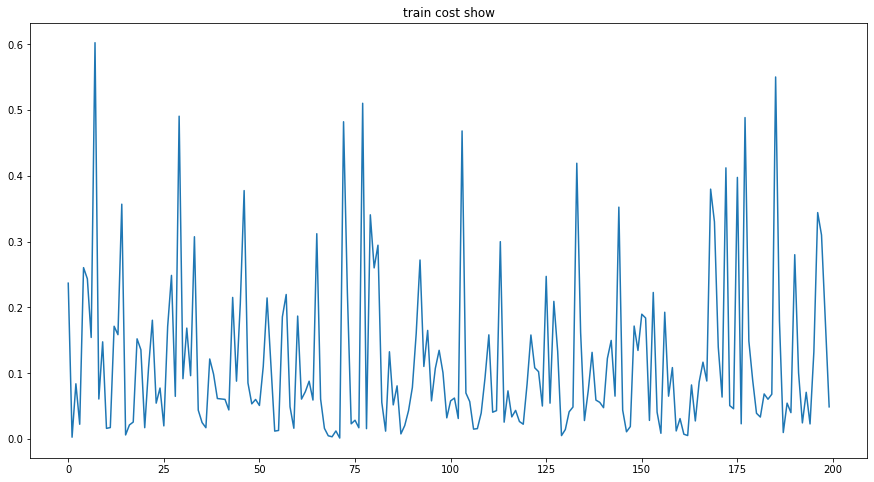

In [19]:
xlabel = np.arange(cost_train.shape[0])
plt.figure(1,[15,8])

plt.title("train cost show")
plt.plot(xlabel[:200], cost_train[:200])
plt.show()

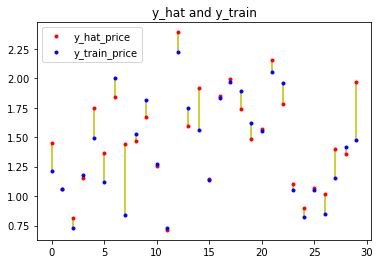

In [20]:
#plt.figure(2,[15,8])
plt.figure(2)
plt.title("y_hat and y_train")
plt.plot(xlabel[:30], y_hat_train_price[:30], '.r', label="y_hat_price" )
plt.plot(xlabel[:30], y_train[:30], '.b', label="y_train_price")
plt.vlines(xlabel[:30], y_hat_train_price[:30], y_train[:30], colors='y')
plt.legend()
plt.show()

In [21]:
distance_test = compute_distances(X_test)
y_hat_test_price = predict_price(distance, weight_triangular, k = 3, trainORtest = False, y_trainning = y_train)

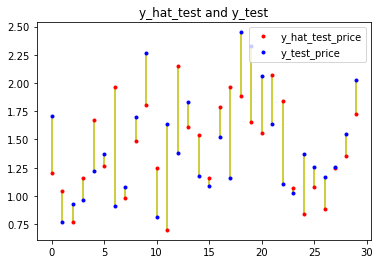

In [22]:
#plt.figure(3,[15,8])
plt.figure(3)
plt.title("y_hat_test and y_test")
plt.plot(xlabel[:30], y_hat_test_price[:30], '.r', label="y_hat_test_price" )
plt.plot(xlabel[:30], y_test[:30], '.b', label="y_test_price")
plt.vlines(xlabel[:30], y_hat_test_price[:30], y_test[:30], colors='y')
plt.legend()
plt.show()